In [1]:
import numpy as np
import pandas as pd

In [2]:
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

In [3]:
import os

Fs = 500
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

train_features = np.zeros([0,8])
train_labels = np.zeros([0])
test_features = np.zeros([0,8])
test_labels = np.zeros([0])
for shift in range(0,1): 
    for files in sorted(os.listdir(f'Subject_4/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        if int(class_) in [1,2,3]:
            df = pd.read_csv(f'Subject_4/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
            data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
            data_arr -= 121
            data_arr /= 255.0
            feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
            
            if not class_.startswith('9'):
                rms_feature = feaData.sum(0)
                baseline = 2*rms_feature[-50:].mean()
                start_ = np.argmax(rms_feature[::1]>baseline)
                end_  = -np.argmax(rms_feature[::-1]>baseline)
                feaData = feaData.T[start_:end_]
            else:
                feaData = feaData.T
            if rep_.startswith('2'):
                test_features = np.concatenate([test_features,feaData])
                test_labels = np.concatenate([test_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
            else:
                train_features = np.concatenate([train_features,feaData])
                train_labels = np.concatenate([train_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
print(start_)
print(end_)
print(feaData)
# print(train_features)
# print(train_labels) 
# print(test_features)
# print(test_labels)

29
-78
[[0.00710845 0.02283901 0.0089285  ... 0.00437549 0.00194067 0.00316911]
 [0.00981592 0.02061442 0.01116239 ... 0.00600773 0.00194067 0.00367364]
 [0.01208059 0.03222628 0.01753779 ... 0.00633821 0.00237683 0.00504202]
 ...
 [0.01418374 0.23719324 0.01074696 ... 0.01197622 0.00336134 0.00367364]
 [0.00780302 0.17676468 0.00784314 ... 0.00280112 0.00185805 0.00336134]
 [0.00701959 0.11501116 0.00708634 ... 0.0042296  0.00158455 0.00354317]]


In [4]:
print(type(train_features))
print(type(train_labels))
print(train_features.shape)

print(test_features.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(794, 8)
(806, 8)


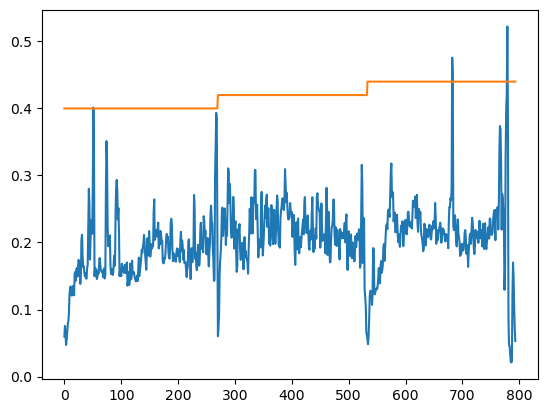

In [5]:
import matplotlib.pyplot as plt
plt.plot(train_features.sum(1))
plt.plot(train_labels/50+ 0.4)

In [6]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='l2', C=100).fit(train_features, train_labels)
reg.score(train_features, train_labels)#, reg.score(test_features, test_labels)

/home/ros-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9748110831234257

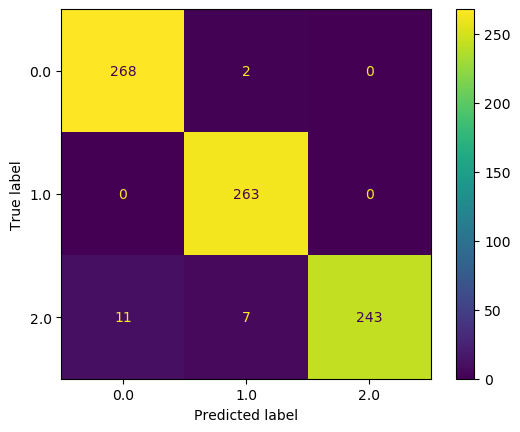

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(train_labels, reg.predict(train_features)),
                            display_labels=reg.classes_)
disp.plot()

In [8]:
from joblib import dump, load
dump(reg, 'LogisticRegression1.joblib') 

['LogisticRegression1.joblib']

In [9]:
accuracy_list = []
accuracy_list = [reg.score(test_features,test_labels)]


In [10]:
accuracy_list

[0.9528535980148883]